In [1]:
import numpy as np
import torch
from torch import utils
import pandas as pd
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch import nn
from torch.nn import functional as F
import pytorch_lightning as pl
from matplotlib import pyplot as plt
from scipy import signal as sig
import os
from pathlib import Path
import re
from torch.utils import data
import pandas as pd
import numpy as np
from smooth import preproc
from pathlib import Path
from dataloader import LandmarkDataset, SequenceDataset
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix, accuracy_score

pd.set_option('mode.chained_assignment', None)

In [3]:
!ls /home/orel/Storage

Data  lost+found  Projects


In [2]:
data_root = Path("/home/orel/Storage/Data/K6/")
landmark_files = []
for subdir in os.listdir(data_root):
    for file in os.listdir(data_root/subdir/'Down'):
        if re.match(r"00\d*DeepCut_resnet50_Down2May25shuffle1_1030000\.h5", file):
            lfile = data_root/subdir/'Down'/file
            landmark_files.append(lfile)

In [3]:
from torch import distributions as D
from torch.distributions import kl_divergence, Normal, Laplace, Categorical

class LatentDistribution(nn.Module):
    prior = Normal(0, 1)
    def __init__(self, in_features, out_features, sigma=None, same_sigma=False):
        super(LatentDistribution, self).__init__()
        self.mu_fc = nn.Linear(in_features, out_features)
        if sigma:
            self.sigma = sigma
        else:
            if same_sigma:
                self.logvar_fc = nn.Linear(in_features, 1)
            else:
                self.logvar_fc = nn.Linear(in_features, out_features) 
    
    def forward(self, x):
        mu = self.mu_fc(x)
        if hasattr(self, 'sigma'):
            sigma = self.sigma
        else:
            logvar = self.logvar_fc(x)
            sigma = torch.exp(logvar / 2)
        self.dist = Normal(mu, sigma)
        return self.dist
    
    def sample(self, l=1):
        return self.dist.rsample()

    def kl_loss(self, prior=None):
        if not prior:
            prior = self.prior
        return kl_divergence(self.dist, prior).sum(dim=-1)

In [31]:
class VariationalAutoencoder(nn.Module):
    prior = Normal(0, 1)
    def __init__(self, n_neurons=[784, 512, 256, 10], batch_norm=True, k=10):
        super(VariationalAutoencoder, self).__init__()
        n_layers = len(n_neurons) - 1
        layers = list()
        for i in range(n_layers-1):
            layers.append(nn.Linear(n_neurons[i], n_neurons[i+1]))
            if batch_norm:
                layers.append(nn.BatchNorm1d(n_neurons[i+1]))
            layers.append(nn.ELU())
        self.encoder = nn.Sequential(*layers)
        self.latent_dist = LatentDistribution(n_neurons[-2], n_neurons[-1])

        layers = list()
        n_neurons = n_neurons[::-1]
        for i in range(n_layers-1):
            layers.append(nn.Linear(n_neurons[i], n_neurons[i+1]))
            if batch_norm:
                layers.append(nn.BatchNorm1d(n_neurons[i+1]))
            layers.append(nn.ELU())
        self.decoder = nn.Sequential(*layers)
        self.sigma = nn.Parameter(torch.ones(1), requires_grad=True)
        self.out_dist = LatentDistribution(n_neurons[-2], n_neurons[-1])

#     def encode(self, x):
#         x = self.encoder(x)
#         return self.latent_dist(x).loc

    def encode(self, data, batch_size=256):
        dl = DataLoader(data, batch_size=batch_size, shuffle=False)
        X = []
        self.cuda()
        with torch.no_grad():
            for bx in dl:
                x_encoded = self.latent_dist(self.encoder(bx.cuda())).loc
                X.append(x_encoded.cpu().numpy())
        X_encoded = np.concatenate(X)
        return X_encoded
    
    # cluster the data using K Means on the encoded data. The data is in the form of SequenceDataset.
    def cluster(self, data, batch_size=256, n_clusters=30):
        X_encoded = self.encode(data, batch_size=batch_size)
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(X_encoded)
        return labels
    
    def forward(self, x):
        x = self.encoder(x)
        z_dist = self.latent_dist(x)
        z = self.latent_dist.sample()
        dist_out = self.out_dist(self.decoder(z))
        return dist_out

    def shared_step(self, batch):
        bx = batch
        dist_x = self.forward(bx)
        rec_loss = - dist_x.log_prob(bx).sum(dim=-1)
        kl_loss = self.latent_dist.kl_loss()
        mse_loss = F.mse_loss(dist_x.loc, bx)
        loss = rec_loss + kl_loss
        return loss.mean(), rec_loss.mean(), kl_loss.mean(), mse_loss

In [33]:
class PLAutoencoder(pl.LightningModule):
    def __init__(self, n_neurons=[784, 512, 256, 10], lr=1e-3, batch_norm=True, seqlen=30, landmark_files=[]):
        super(PLAutoencoder, self).__init__()
        self.hparams = {'lr': lr}
        self.seqlen = seqlen
        self.landmark_files = landmark_files
        self.model = VariationalAutoencoder(n_neurons, batch_norm=batch_norm)

    def forward(self, x):
        return self.model(x)

    def prepare_data(self):
        landmark_datasets = []
        for file in self.landmark_files:
            try:
                ds = LandmarkDataset(file)
                landmark_datasets.append(ds)
            except OSError:
                pass
        coords = [sig.decimate(ds.coords, q=4, axis=0).astype(np.float32) for ds in landmark_datasets]
        N, n_coords, _ = coords[0].shape
        train_data = [crds[:int(0.8*crds.shape[0])].reshape(-1, n_coords*2) for crds in coords]
        valid_data = [crds[int(0.8*crds.shape[0]):].reshape(-1, n_coords*2) for crds in coords]
        train_dsets = [SequenceDataset(data, seqlen=self.seqlen, step=1, diff=False) for data in train_data]
        valid_dsets = [SequenceDataset(data, seqlen=self.seqlen, step=10, diff=False) for data in valid_data]
        self.train_ds = ConcatDataset(train_dsets)
        self.valid_ds = ConcatDataset(valid_dsets)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=256, shuffle=True, num_workers=4)

    def val_dataloader(self):
        # dataset = SequenceDataset(X_val, seqlen=30, step=5, diff=True)
        return DataLoader(self.valid_ds, batch_size=256, shuffle=False, num_workers=4)

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), self.hparams['lr'])
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.2 ,patience=20, verbose=True, min_lr=1e-6)
        scheduler = {'scheduler': sched, 'interval': 'epoch', 'monitor': 'val_checkpoint_on', 'reduce_on_plateau': True}
        return opt
    
    def training_step(self, batch, batch_idx):
        loss, rec_loss, kl_loss, mse_loss = self.model.shared_step(batch)
        result = pl.TrainResult(loss)
        result.log('train_loss', loss, prog_bar=True)
        result.log("train_rec_loss", rec_loss, prog_bar=True)
        result.log('train_kl_loss', kl_loss, prog_bar=True)
        result.log('train_mse_loss' ,mse_loss, prog_bar=True)
        return result

    def validation_step(self, batch, batch_idx):
        loss, rec_loss, kl_loss, mse_loss  = self.model.shared_step(batch)
        result = pl.EvalResult(loss)
        result.log('eval_loss', loss, prog_bar=True)
        result.log("eval_rec_loss", rec_loss, prog_bar=True)
        result.log('eval_kl_loss', kl_loss, prog_bar=True)
        result.log('eval_mse_loss' ,mse_loss, prog_bar=True)
        return result

In [ ]:
seqlen = 30
model = PLAutoencoder(n_neurons=[2*12*seqlen, 1024, 1024, 512, 32], lr=3e-4, seqlen=seqlen, landmark_files=landmark_files)
trainer = pl.Trainer(gpus=1, progress_bar_refresh_rate=10, max_epochs=50, )
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | VariationalAutoencoder | 5 M   


/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning: The metric you returned None must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of loss in validation_epoch_end()?
  warnings.warn(*args, **kwargs)
/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning: Can save best model only with loss available, skipping.
  warnings.warn(*args, **kwargs)


In [10]:
# from simple_autoencoder import PLAutoencoder
# import importlib
# importlib.reload(simple_autoencoder)

%pdb off
seqlen = 30
model = PLAutoencoder(n_neurons=[2*12*seqlen, 1024, 1024, 512, 32], lr=3e-4, seqlen=seqlen, landmark_files=landmark_files)
trainer = pl.Trainer(gpus=1, progress_bar_refresh_rate=10, max_epochs=50, )
trainer.fit(model)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Automatic pdb calling has been turned OFF


/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | VariationalAutoencoder | 4 M   


/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning: The metric you returned None must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of loss in validation_epoch_end()?
  warnings.warn(*args, **kwargs)
/home/shuki/anaconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning: Can save best model only with loss available, skipping.
  warnings.warn(*args, **kwargs)


Saving latest checkpoint..


1

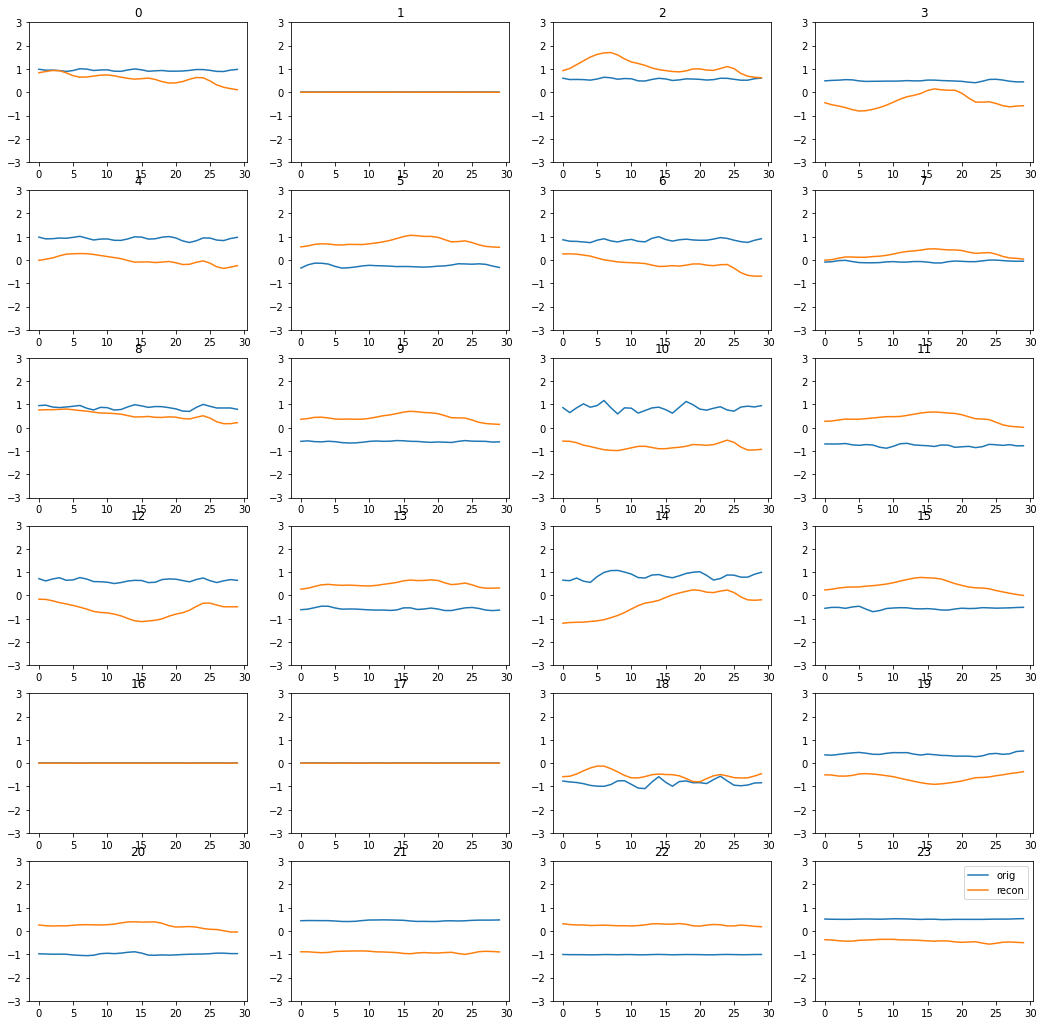

In [28]:
def compare_plot(x, y):
    x = x.reshape(seqlen, 24)
    y = y.reshape(seqlen, 24)
    fig, axes = plt.subplots(ncols=4, nrows=6, figsize=(18, 18))
    for i in range(6):
        for j in range(4):
            idx = 4*i + j
            axes[i][j].plot(x[:,idx], label='orig')
            axes[i][j].plot(y[:,idx], label='recon')
            axes[i][j].set_title(f"{idx}")
            axes[i][j].set_ylim(-3, 3)
    plt.legend()
compare_plot(bx[190].cpu().numpy(), out.loc[190].cpu().numpy())

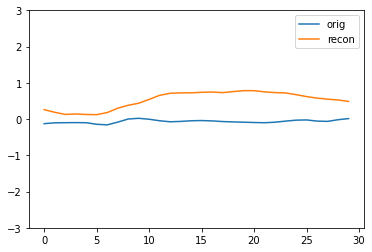

In [17]:
dl = model.val_dataloader()
bx = next(iter(dl))
with torch.no_grad():
    out = model(bx)
plt.plot(bx[150].cpu().numpy().reshape(seqlen, 24)[:,7], label='orig')
plt.plot(out.loc[150].cpu().numpy().reshape(seqlen, 24)[:,7], label='recon')
plt.ylim((-3, 3))
plt.legend()

In [95]:
landmark_datasets = []
for file in landmark_files:
    try:
        ds = LandmarkDataset(file)
        landmark_datasets.append(ds)
    except OSError:
        pass
coords = [sig.decimate(ds.coords, q=4, axis=0).astype(np.float32) for ds in landmark_datasets]

In [153]:
N, n_coords, _ = coords[0].shape
all_data = [crds.reshape(-1, n_coords*2) for crds in coords]
data_lengths = [d.shape[0] - model.seqlen for d in all_data]
video_change_idxs = np.cumsum(data_lengths)[:-1]
all_data = [SequenceDataset(d, seqlen=model.seqlen, diff=False, step=1) for d in all_data]
all_data = ConcatDataset(all_data)

In [154]:
labels = model.model.cluster(all_data, batch_size=1024)

'''
split the sequence of labels and returns the sequence of segments of the form:
      [(label0, segment_start0, segment_length0), ...]
for example:
44422222227777  ->  [(4, 0, 3), (2, 7), (7, 4)]
'''
def split_labels(labels):
    split_at = np.where(np.diff(labels) != 0)[0] + 1
    sequence = [[seg[0], split_at[i-1]*4 + model.seqlen*2, len(seg)*4] \
                for i, seg in enumerate(np.split(labels, indices_or_sections=split_at))]
    sequence[0][1] = model.seqlen*2
    return sequence

labels_dict = dict(zip(landmark_files, 
                        np.split(labels, indices_or_sections=video_change_idxs)))


segment_dict = dict(zip(landmark_files, 
                        map(split_labels, np.split(labels, indices_or_sections=video_change_idxs))))


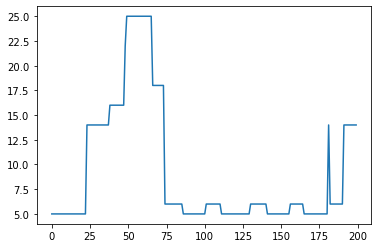

In [156]:
lbls = labels_dict[landmark_files[6]]
plt.plot(lbls[:200])

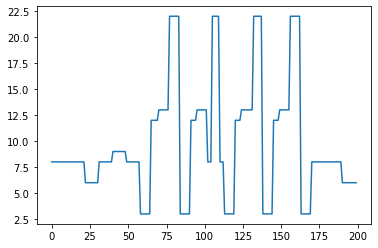

In [114]:
lbls = labels_dict[landmark_files[6]]


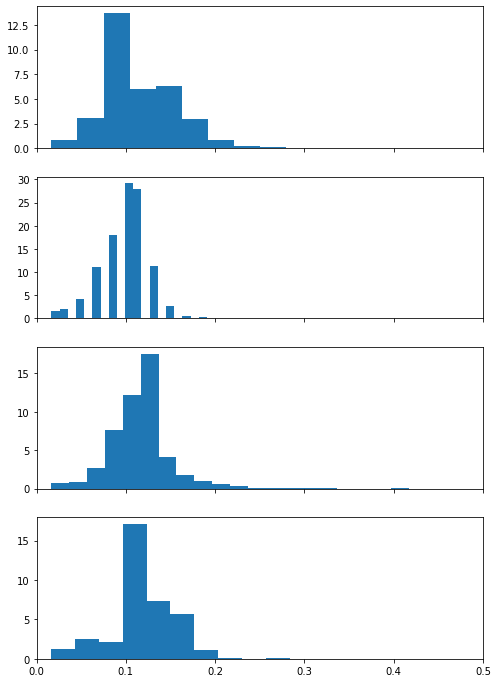

In [144]:
from collections import defaultdict
segments = split_labels(labels)
segment_lengths = defaultdict(list)
for seg in segments:
    if seg[2] < 200:
        segment_lengths[seg[0]].append(seg[2]/(4*60))
    
fig, axes = plt.subplots(ncols=1, nrows=4, figsize=(8, 12), sharex=True)
for i, cl in enumerate([3, 12, 13, 22]):
    axes[i].hist(segment_lengths[cl], bins=20, density=True)
    axes[i].set_xlim(0, 0.5)

In [129]:
p = landmark_files[0]
re.sub(r'DeepCut.*\.h5', '.mp4', p.name)

'0011.mp4'

In [159]:
import cv2 as cv
import importlib
import random
import clip_videos
from collections import defaultdict
importlib.reload(clip_videos)

def save_clips(landmarks_file, cluster_segments, save_dir, min_seg_len=10):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    video_file = re.sub(r'DeepCut.*\.h5', '.MP4', landmarks_file.name)
    video_file = landmarks_file.parent / video_file
    assert os.path.exists(video_file)
    cluster_frames = defaultdict(list)
    for seg in cluster_segments:
        if seg[2] >= min_seg_len:
            cluster_frames[seg[0]].append((seg[1] + seg[2]//2, seg[2]//2))
    cluster_frames = {k: v for k, v in cluster_frames.items() if len(v) >= 15}
    cluster_samples = {c: random.choices(cl, k=15) for c, cl in cluster_frames.items()}
    df = LandmarkDataset(landmarks_file).df
    for cl_id,  cluster in cluster_samples.items():
        mid_frames = [c[0] for c in cluster]
        n_frames = [c[1] for c in cluster]
        n_frames = int(min(60, np.mean(n_frames) + np.std(n_frames)))
        clip_videos.save_collage_with_labels_short(str(video_file), df, mid_frames, n_frames_around=n_frames,
                                             save_file=f'{save_dir}/cluster_{cl_id}.mp4')

In [160]:
lfile = landmark_files[0]
save_clips(lfile, segment_dict[lfile], f'clusters/sept15/{lfile.name[:4]}')

[250090, 150264, 174264, 428042, 201668, 429634, 259370, 428716, 70, 429544, 259164, 155242, 10522, 6430, 36120]
[231186, 353376, 213500, 428630, 155178, 200180, 174382, 36150, 214130, 202046, 353376, 427742, 36246, 36150, 37542]
[6570, 231052, 201970, 170448, 170448, 110492, 6570, 201862, 201638, 273524, 357614, 174324, 14860, 14776, 205862]
[1954, 275624, 428248, 170778, 12716, 232124, 213416, 283958, 225128, 273126, 269708, 10820, 159296, 272840, 892]
[2346, 170130, 46872, 104018, 172006, 430402, 37130, 239812, 430402, 374208, 222848, 108682, 1100, 38674, 408902]
[174004, 173738, 428466, 38972, 428466, 230698, 172156, 524, 173738, 2544, 429436, 249670, 14622, 427594, 158912]
[351596, 109366, 309434, 351596, 354838, 35088, 10790, 6940, 167170, 270498, 150880, 260160, 100540, 147856, 314100]
[255412, 14424, 206924, 205660, 248428, 206924, 233866, 206924, 356786, 66742, 150000, 150000, 46516, 233866, 248428]
[144342, 3738, 4152, 444868, 20598, 241484, 67142, 221846, 107984, 115918, 107

In [161]:
for lfile, segments in segment_dict.items():
    save_dir = f'clusters/sept15/{lfile.name[:4]}'
    if not os.path.exists(save_dir):
        save_clips(lfile, segments, save_dir)

[39174, 75374, 222202, 309008, 357004, 119696, 149620, 114742, 392328, 119822, 114742, 358466, 149722, 149404, 75374]
[177284, 119736, 148910, 277752, 114914, 359042, 215828, 115366, 178392, 146762, 148910, 215626, 332168, 308828, 382366]
[1330, 120004, 35136, 115436, 392070, 89300, 273030, 178426, 391942, 177316, 35246, 68122, 356826, 215744, 222268]
[39250, 120084, 332538, 88500, 39250, 273482, 91298, 91142, 357316, 394770, 3856, 146958, 219646, 310974, 357316]
[257952, 59128, 228438, 373422, 251442, 285554, 418208, 178020, 34272, 417380, 155892, 116054, 151146, 56442, 38534]
[193974, 275092, 30266, 27836, 413672, 309412, 116112, 395308, 362882, 367736, 295212, 68760, 219832, 427416, 78494]
[120444, 314106, 237192, 407558, 134728, 371758, 39320, 174966, 360562, 100574, 79280, 28420, 88668, 37290, 221582]
[133802, 262338, 379994, 16162, 126814, 30004, 244358, 136464, 136464, 379994, 176456, 127034, 80116, 29682, 55908]
[374852, 138770, 81862, 130960, 376348, 19906, 780, 245050, 133428

AssertionError: 

In [ ]:
from collections import defaultdict
import random
split_at = np.where(np.diff(labels) != 0)[0] + 1
sequence = [[s[0], split_at[i-1], len(s)] for i, s in enumerate(np.split(labels, indices_or_sections=split_at))]
sequence[0][1] = 0
seg_lengths = defaultdict(list)
for seg in sequence:
    seg_lengths[seg[0]].append(seg[2])

sequence = [seq for seq in sequence if seq[2] > 5]

cluster_frames = defaultdict(list)
for seq in sequence:
    cluster_frames[seq[0]].append((seq[1]*4 + seq[2]*2, seq[2]*2))

cluster_frames = {c:cl for c, cl in cluster_frames.items() if len(cl)>25}
# len(cluster_frames)
cluster_samples = {c: random.choices(cl, k=15) for c, cl in cluster_frames.items()}

In [ ]:
F.softplus(torch.Tensor(np.array([-3])), beta=2)

In [ ]:
import cv2 as cv
import importlib
import clip_videos
importlib.reload(clip_videos)

video_file = data_root/'2020-03-23'/'Down'/'0008DeepCut_resnet50_Down2May25shuffle1_1030000_labeled.mp4'

In [ ]:
for cl_id,  cluster in cluster_samples.items():
    n_frames = [c[1] for c in cluster]
    print(cl_id, np.mean(n_frames), np.std(n_frames))

In [ ]:
df = LandmarkDataset(landmarks_file).df
for cl_id,  cluster in cluster_samples.items():
    mid_frames = [c[0] for c in cluster]
    n_frames = [c[1] for c in cluster]
    n_frames = int(min(60, np.mean(n_frames) + np.std(n_frames)))
    print(mid_frames)
    clip_videos.save_collage_with_labels_short(str(video_file), df, mid_frames, n_frames_around=n_frames,
                                         save_file=f'clusters/example_1/cluster_{cl_id}.mp4')

In [ ]:
writer.write(np.zeros())

In [ ]:
!ls clusters/example_1

In [ ]:
# sequence = [seq[0] for seq in sequence]
from collections import defaultdict, Counter

def count_ngrams(sequence, max_n=10):
    N = len(sequence)
    counter = defaultdict(int)
    for k in range(1, max_n):
        for i in range(N-k):
            counter[tuple(sequence[i:i+k])] += 1
    return counter

def segment_sequence(sequence, max_n=5):
    N = len(sequence)
    sequence = tuple(sequence)
    ngram_count = count_ngrams(sequence, max_n=max_n)
    u_arr = np.zeros(N - 1)
    for k in range(0, N - 1):
        u_k = 0
        for n in range(2, min(max_n, k, N-k)):
            s_1, s_2 = ngram_count[sequence[k-n+1:k+1]], ngram_count[sequence[k+1:k+n+1]]
            u_k += np.mean([1 if s_1 >= ngram_count[sequence[k-n+i+1:k+i+1]] else 0 for i in range(1, n)])
            u_k += np.mean([1 if s_2 >= ngram_count[sequence[k-n+i+1:k+i+1]] else 0 for i in range(1, n)])
        u_arr[k] = u_k / max_n / 2
    
    sequence = list(sequence)
    segments = []
    prev_idx = 0
    for idx in range(1, N-1):
        if u_arr[idx-1] < u_arr[idx] and u_arr[idx+1] < u_arr[idx]:
            segments.append(sequence[prev_idx:idx+1])
            prev_idx = idx+1

    segments.append(sequence[prev_idx:])
    return segments

segments = segment_sequence(sequence, max_n=10)

In [ ]:
Counter(map(tuple, segments)).most_common(30)

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(labels[:2000])

In [ ]:
labels[:100]
27, 8, 26, 4, 10, 27, 8, 26, 4, 10, 27, 8, 26

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(labels[3*10**4+1500:3*10**4+3000])

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(labels[10**5+1500:10**5+3000])
# plt.plot(labels[250:400])

In [ ]:
re.search(r"(a+b+c+)+", "daaabbbccabc")

In [ ]:
chars = [chr(i) for i in range(ord('A'), ord('Z'))] + [chr(i) for i in range(ord('a'), ord('z'))]
labels_string = ''.join([chars[l] for l in labels])
labels_string[280:400]

In [ ]:
pat = re.compile(r"(K+Q+M+d+b+)+")
spans = [match.span() for match in re.finditer(pat, labels_string)]
span_lengths = [span[1] - span[0] for span in spans]
spans[3] 

In [ ]:
pat = re.compile(r"K+(?!Q*K+)")
fspans = [match.span() for match in re.finditer(pat, labels_string)]
fspans = [(max(0, s[0]-30), s[1]+30) for s in fspans]
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(18, 20))
for i in range(10):    
    for ipart, part in enumerate(landmarks_data.body_parts):
        if part in ['forepawR', 'forePawL', 'hindpawR', 'hindpawL']:
            axes[i][0].plot(coords[fspans[i][0]+15: fspans[i][1]+15,ipart,0], label=f"{part}_x")
            axes[i][0].plot(coords[fspans[i][0]+15: fspans[i][1]+15,ipart,1], label=f"{part}_y")
    axes[i][1].plot(labels[slice(*fspans[i])])
    axes[i][0].legend(loc='right')

In [ ]:
print(len(re.findall(r"K+(?!K*Q+)", labels_string)))
print(len(re.findall(r"K+Q+(?!Q*M+)", labels_string)))
print(len(re.findall(r"K+Q+M+(?!M*d+)", labels_string)))
print(len(re.findall(r"K+Q+M+d+(?!d*b+)", labels_string)))


In [ ]:
fig, axes = plt.subplots(nrows=50, ncols=2, figsize=(18, 200))
for i in range(50):    
    for ipart, part in enumerate(landmarks_data.body_parts):
        if part in ['forepawR', 'forePawL', 'hindpawR', 'hindpawL']:
            axes[i][0].plot(coords[spans[i][0]+15: spans[i][1]+15,ipart,0], label=f"{part}_x")
            axes[i][0].plot(coords[spans[i][0]+15: spans[i][1]+15,ipart,1], label=f"{part}_y")
    axes[i][1].plot(labels[slice(*spans[i])])
    axes[i][0].legend(loc='right')

In [ ]:
plt.figure(figsize=(20, 4))
plt.plot(labels[:1000])

In [ ]:
n_clusters = len(set(labels))
transition_matrix = np.zeros((n_clusters, n_clusters))
for i in range(len(labels) - 1):
    transition_matrix[labels[i], labels[i+1]] += 1.

np.fill_diagonal(transition_matrix, val=0)

transition_matrix /= transition_matrix.sum(axis=0, keepdims=True)
plt.imshow(transition_matrix)

In [ ]:
def split(idx_arr):
    to_split = np.where(np.abs(np.diff(idx_arr)) > 1)[0] + 1
    return np.split(idx_arr, indices_or_sections=to_split)
behaviors = [split(np.where(y_gold==lbl)[0]) for lbl in set(y_gold)]
sections = [np.stack([np.mean(X_encoded[sec], axis=0) for sec in beh]) for beh in behaviors]
sections[1].shape